In [1]:
from dieboldmariano import dm_test
import utils.DataSplitter
from utils.metrics import *
from utils.ColumnEnum import Columns
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

def getData(level, line, target, printInfo=False):
    if level == 60:
        agg = 1
    elif level == 30:
        agg = 2
    elif level == 15:
        agg = 4

    to_drop = [target]

    df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
    df_train = df_level[df_level['line'] == line]

    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                            dropSpecific=to_drop)
    y_train = df_train[target]

    df_train.index = pd.RangeIndex(start=0, stop=df_train.shape[0])
    X_train.index = df_train.index
    y_train.index = df_train.index


    df_level_test = utils.DataSplitter.getTestData(agglevel=level, diff=False)
    df_test = df_level_test[df_level_test['line'] == line]

    X_test = utils.DataSplitter.subsetColumns(df_test, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                            dropSpecific=to_drop)
    y_test = df_test[target]

    df_test.index = pd.RangeIndex(start = X_train.shape[0], stop = X_train.shape[0] + X_test.shape[0])
    X_test.index = df_test.index
    y_test.index = df_test.index

    if printInfo:
        print(all(X_train.columns == X_test.columns))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        print(X_train.columns)

    return y_test, df_test

y_test, df_test = getData(level, line, target, printInfo=True)

True
(16520, 29) (16520,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


In [3]:
SNaive_preds1A = np.load("predictions/1ASNaive_test_predictions.npy").tolist()
SNaive_preds2A = np.load("predictions/2ASNaive_test_predictions.npy").tolist()
SNaive_preds3A = np.load("predictions/3ASNaive_test_predictions.npy").tolist()
SNaive_preds4A = np.load("predictions/4ASNaive_test_predictions.npy").tolist()
SNaive_preds5A = np.load("predictions/5ASNaive_test_predictions.npy").tolist()
SNaive_preds6A = np.load("predictions/6ASNaive_test_predictions.npy").tolist()
Lasso_preds1A = np.load("predictions/1ALCW_Lasso_test_predictions.npy").tolist()
Lasso_preds2A = np.load("predictions/2ALCW_Lasso_test_predictions.npy").tolist()
Lasso_preds3A = np.load("predictions/3ALCW_Lasso_test_predictions.npy").tolist()
Lasso_preds4A = np.load("predictions/4ALCW_Lasso_test_predictions.npy").tolist()
Lasso_preds5A = np.load("predictions/5ALCW_Lasso_test_predictions.npy").tolist()
Lasso_preds6A = np.load("predictions/6ALCW_Lasso_test_predictions.npy").tolist()
RF_preds1A = np.load("predictions/1ALCW_RF_test_predictions.npy").tolist()
RF_preds2A = np.load("predictions/2ALCW_RF_test_predictions.npy").tolist()
RF_preds3A = np.load("predictions/3ALCW_RF_test_predictions.npy").tolist()
RF_preds4A = np.load("predictions/4ALCW_RF_test_predictions.npy").tolist()
RF_preds5A = np.load("predictions/5ALCW_RF_test_predictions.npy").tolist()
RF_preds6A = np.load("predictions/6ALCW_RF_test_predictions.npy").tolist()
XGB_preds1A = np.load("predictions/1ALC_XGB_test_predictions.npy").tolist()
XGB_preds2A = np.load("predictions/2ALC_XGB_test_predictions.npy").tolist()
XGB_preds3A = np.load("predictions/3ALC_XGB_test_predictions.npy").tolist()
XGB_preds4A = np.load("predictions/4ALC_XGB_test_predictions.npy").tolist()
XGB_preds5A = np.load("predictions/5ALC_XGB_test_predictions.npy").tolist()
XGB_preds6A = np.load("predictions/6ALC_XGB_test_predictions.npy").tolist()
RNN_preds1A = np.load("predictions/1ALC_RNN_test_predictions.npy").tolist()
RNN_preds2A = np.load("predictions/2ALC_RNN_test_predictions.npy").tolist()
RNN_preds3A = np.load("predictions/3ALC_RNN_test_predictions.npy").tolist()
RNN_preds4A = np.load("predictions/4ALC_RNN_test_predictions.npy").tolist()
RNN_preds5A = np.load("predictions/5ALC_RNN_test_predictions.npy").tolist()
RNN_preds6A = np.load("predictions/6ALC_RNN_test_predictions.npy").tolist()
LSTM_preds1A = np.load("predictions/1ALC_LSTM_test_predictions.npy").tolist()
LSTM_preds2A = np.load("predictions/2ALC_LSTM_test_predictions.npy").tolist()
LSTM_preds3A = np.load("predictions/3ALC_LSTM_test_predictions.npy").tolist()
LSTM_preds4A = np.load("predictions/4ALC_LSTM_test_predictions.npy").tolist()
LSTM_preds5A = np.load("predictions/5ALC_LSTM_test_predictions.npy").tolist()
LSTM_preds6A = np.load("predictions/6ALC_LSTM_test_predictions.npy").tolist()

preds_1A = [SNaive_preds1A, Lasso_preds1A, RF_preds1A, XGB_preds1A, RNN_preds1A, LSTM_preds1A]
preds_2A = [SNaive_preds2A, Lasso_preds2A, RF_preds2A, XGB_preds2A, RNN_preds2A, LSTM_preds2A]
preds_3A = [SNaive_preds3A, Lasso_preds3A, RF_preds3A, XGB_preds3A, RNN_preds3A, LSTM_preds3A]
preds_4A = [SNaive_preds4A, Lasso_preds4A, RF_preds4A, XGB_preds4A, RNN_preds4A, LSTM_preds4A]
preds_5A = [SNaive_preds5A, Lasso_preds5A, RF_preds5A, XGB_preds5A, RNN_preds5A, LSTM_preds5A]
preds_6A = [SNaive_preds6A, Lasso_preds6A, RF_preds6A, XGB_preds6A, RNN_preds6A, LSTM_preds6A]
best_preds = [RNN_preds1A, RNN_preds2A, RNN_preds3A, LSTM_preds4A, RF_preds5A, XGB_preds6A]
model_names = ["Seasonal Naive", "Lasso", "Random Forest Regression", "XGBoost", "Vanilla RNN", "LSTM"]
best_preds_model_names = ["1A - Vanilla RNN", "2A - Vanilla RNN", "3A - Vanilla RNN", "4A - LSTM", "5A - Random Forest Regression", "6A - XGBoost"]

# Plot of Predictions vs Ground Truth

In [121]:
import matplotlib.pyplot as plt

def plotPredsAgainstGT(preds, names, aggLevel, line=[Columns.line_1A.value, Columns.line_2A.value, Columns.line_3A.value, Columns.line_4A.value, Columns.line_5A.value, Columns.line_6A.value]):

    fig, ax = plt.subplots(3, 2, figsize=(10, 8))
    fig.set_tight_layout('h_pad')

    line_values = np.linspace(-10000, 10000, 100)
    
    isGTSet = False
    for i, pred in enumerate(preds):
        if type(line) == str:
            plt.suptitle(f"Line {line} Predictions vs Ground Truth", fontsize=16)
            if not isGTSet:
                gt, _ = getData(aggLevel, line, Columns.target_passengersBoarding.value)
                isGTSet = True
        else:
            plt.suptitle("Predictions vs Ground Truth of Best Models For Each Line", fontsize=16)
            gt, _ = getData(aggLevel, line[i], Columns.target_passengersBoarding.value)

        j = 1 if i >= 3 else 0
        ax[i%3, j].scatter(pred, gt, color="steelblue")
        ax[i%3, j].plot(line_values, line_values, color="black")
        ax[i%3, j].set_xlim(-100, max(pred)+max(pred)//20)
        ax[i%3, j].set_ylim(-100, max(gt)+max(gt)//20)
        ax[i%3, j].set_xlabel("Predicted")
        ax[i%3, j].set_ylabel("GT")
        ax[i%3, j].set_title(names[i])
    

    plt.tight_layout()
    plt.show()

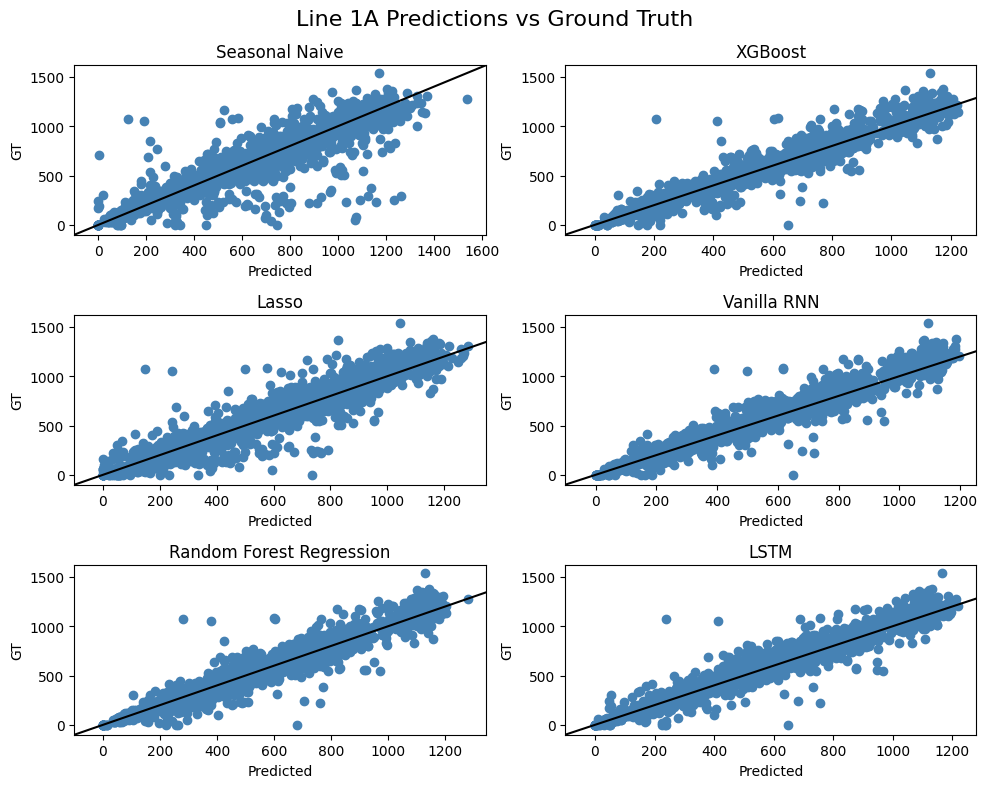

In [122]:
plotPredsAgainstGT(preds_1A, model_names, 60, line=Columns.line_1A.value)

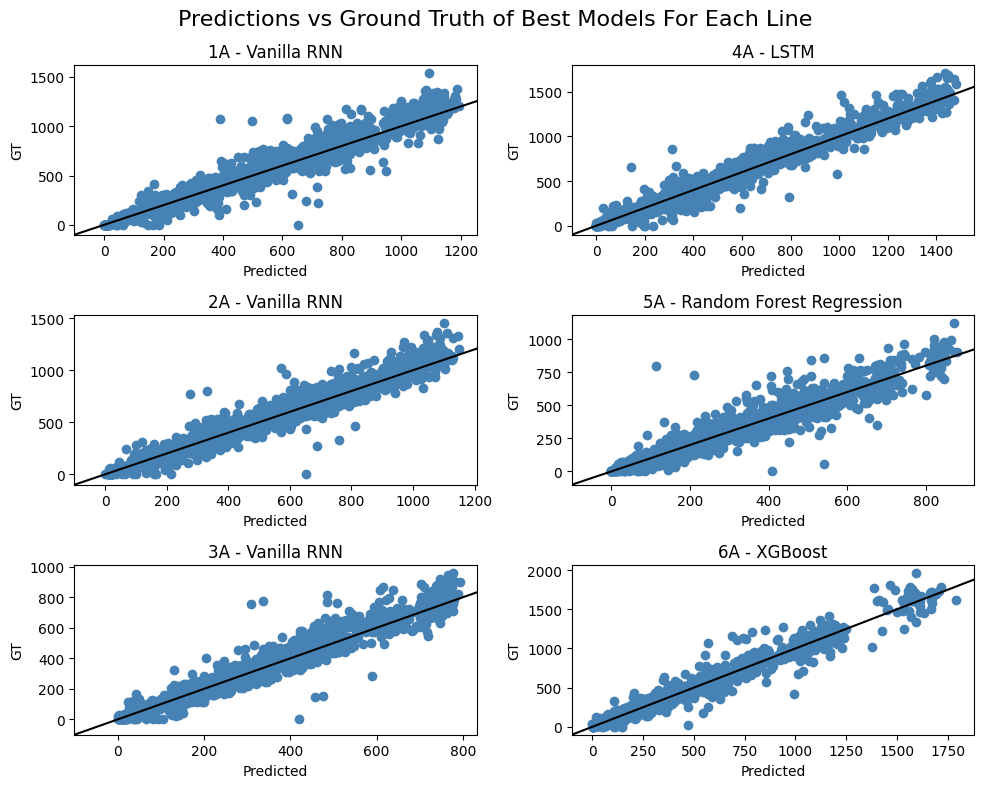

In [123]:
plotPredsAgainstGT(best_preds, best_preds_model_names, 60)

# Diebold Mariano

In [6]:
dm_test(y_test.tolist(), SNaive_preds1A, Lasso_preds1A)

(6.1825433924234545, 7.751265148333892e-10)

# Residual analysis

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [8]:
def adf_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, _, _, _, _ = adfuller(series)
    if hypothesis:
        print("H_0: Time Series is not stationary")
        print("H_A: Time Series is stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Not Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    return test_statistic, p_value

def kpss_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, lags, _ = kpss(series)
    if hypothesis:
        print("H_0: Time Series is stationary")
        print("H_A: Time Series is not stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Not Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    print(f"lags: {lags}")
    return test_statistic, p_value, lags

p-value: 0.001229480659002281 < 0.05 (Stationary)
p-value: 0.1 > 0.05 (Stationary)
lags: 22


C:\Users\Andre\AppData\Local\Temp\ipykernel_4944\2409044522.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test_statistic, p_value, lags, _ = kpss(series)


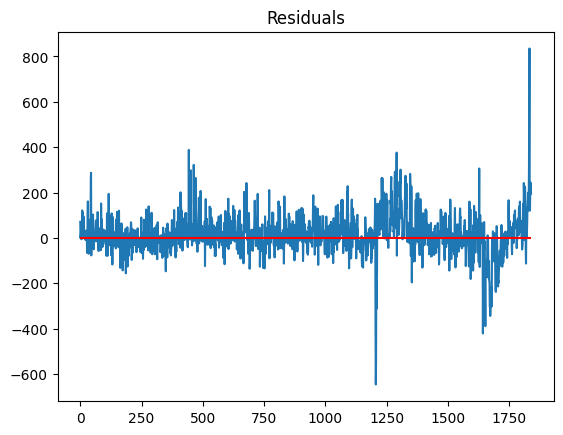

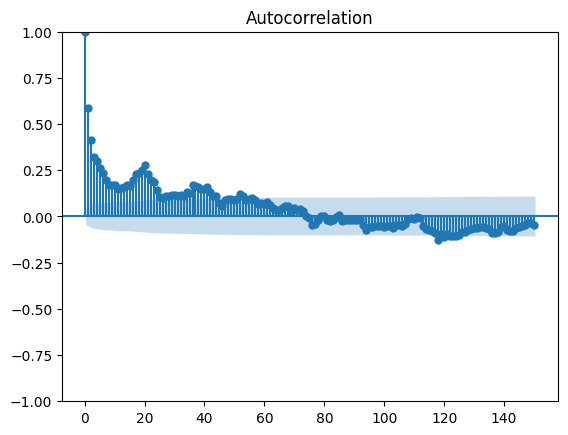

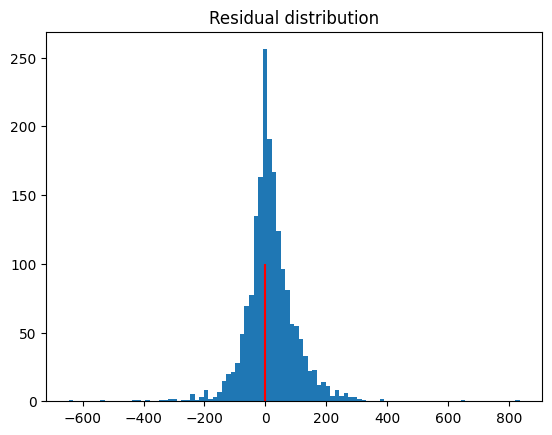

In [9]:
residuals = y_test.to_numpy() - np.array(LSTM_preds1A)
adf_test(residuals)
kpss_test(residuals)

plt.plot(residuals)
plt.title('Residuals')
plt.hlines(y=0, xmin=0, xmax=residuals.shape[0], colors='red')
plt.show()

plot_acf(residuals, lags=150, alpha=0.05)
plt.show()

plt.hist(residuals, bins=100)
plt.title('Residual distribution')
plt.vlines(x=0, ymin=0, ymax=100, colors='red')
plt.show()

# Forecast Horizon Analysis

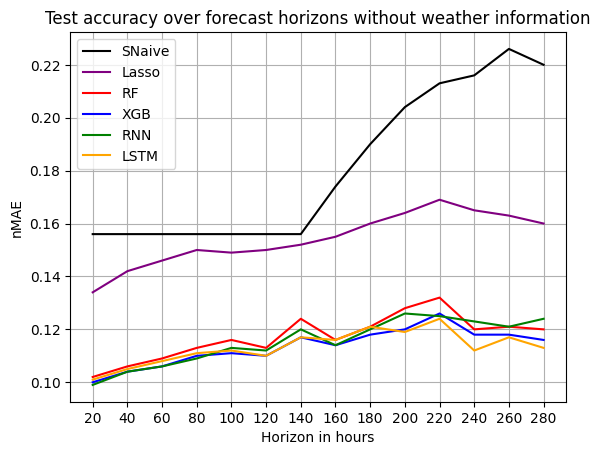

In [10]:
# line 1A on test data without weather
horizons = np.array([i for i in range(20, 280+1, 20)])
SNaive_nMAE = np.array([0.156, 0.156, 0.156, 0.156, 0.156, 0.156, 0.156, 0.174, 0.190, 0.204, 0.213, 0.216, 0.226, 0.220])
Lasso_nMAE = np.array([0.134, 0.142, 0.146, 0.150, 0.149, 0.150, 0.152, 0.155, 0.160, 0.164, 0.169, 0.165, 0.163, 0.160])
RF_nMAE = np.array([0.102, 0.106, 0.109, 0.113, 0.116, 0.113, 0.124, 0.116, 0.121, 0.128, 0.132, 0.120, 0.121, 0.120])
XGB_nMAE = np.array([0.100, 0.104, 0.106, 0.110, 0.111, 0.110, 0.117, 0.114, 0.118, 0.120, 0.126, 0.118, 0.118, 0.116])
RNN_nMAE = np.array([0.099, 0.104, 0.106, 0.109, 0.113, 0.112, 0.120, 0.114, 0.120, 0.126, 0.125, 0.123, 0.121, 0.124])
LSTM_nMAE = np.array([0.101, 0.105, 0.108, 0.111, 0.112, 0.110, 0.117, 0.116, 0.121, 0.119, 0.124, 0.112, 0.117, 0.113])

plt.title('Test accuracy over forecast horizons without weather information')
plt.plot(horizons, SNaive_nMAE, '-', color='black', label='SNaive')
plt.plot(horizons, Lasso_nMAE, '-', color='purple', label='Lasso')
plt.plot(horizons, RF_nMAE, '-', color='red', label='RF')
plt.plot(horizons, XGB_nMAE, '-', color='blue', label='XGB')
plt.plot(horizons, RNN_nMAE, '-', color='green', label='RNN')
plt.plot(horizons, LSTM_nMAE, '-', color='orange', label='LSTM')
plt.legend()
plt.grid()
plt.xlabel('Horizon in hours')
plt.ylabel('nMAE')
plt.xticks(horizons)
plt.show()

# Grouping Forecast Errors

In [11]:
df_test.columns

Index(['date', 'hour', 'peakHour', 'year', 'quarter', 'Q1', 'Q2', 'Q3', 'Q4',
       'month', 'monthNumber', 'weekNumber', 'weekDay', 'dateNumber', 'mon',
       'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'workdayPlan', 'saturdayPlan',
       'sundayAndHolidayPlan', 'summerVacation', 'fallVacation',
       'christmasVacation', 'winterVacation', 'easterVacation', 'line',
       'passengersBoarding', 'acc_precip', 'bright_sunshine',
       'mean_cloud_cover', 'mean_pressure', 'mean_relative_hum', 'mean_temp',
       'mean_wind_speed', 'snow_depth', 'datetime', 'eventName', 'event',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17',
       'lag18', 'lag19', 'lag20', 'lag40', 'lag60', 'lag80', 'lag100',
       'lag120', 'lag140'],
      dtype='object')

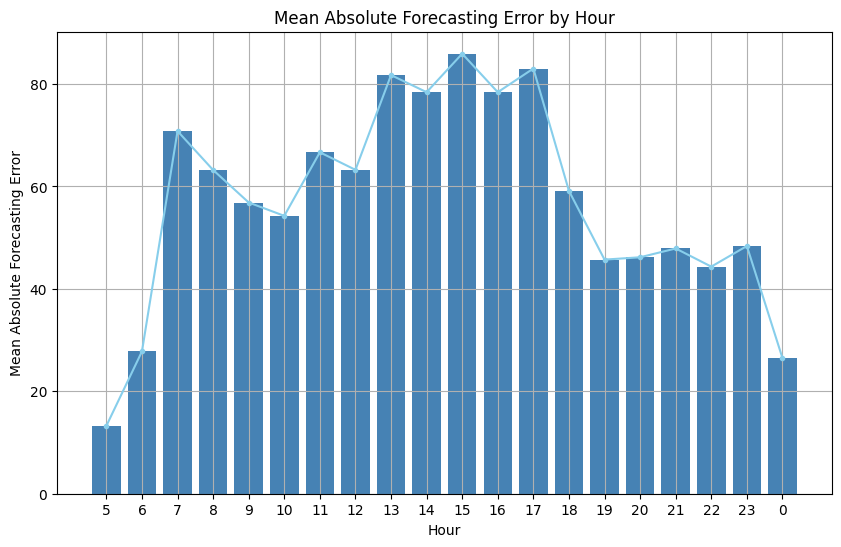

In [28]:
key = "hour"
preds = RNN_preds1A
_, df_test = getData(60, Columns.line_1A.value, Columns.target_passengersBoarding.value)

pred_df = deepcopy(df_test)
pred_df["residuals"] = np.abs(pred_df["passengersBoarding"] - preds)

plt.figure(figsize=(10, 6))
if key == "hour":
    pred_df[key] = pred_df[key].replace(0, 24)
    labels = [str(hour) if hour != 24 else "0" for hour in range(5, 24+1)]
    plt.xticks(range(5, 24+1), labels)
else:
    assert len(pd.unique(pred_df[key])) >= 2, 'must use key with more than one unique value'
    keyMaxValue = max(pred_df[key])
    if len(pd.unique(pred_df[key])) >= 25:
        plt.xticks(range(min(pred_df[key]), keyMaxValue+1, keyMaxValue//8))
    else:
        plt.xticks(range(min(pred_df[key]), keyMaxValue+1))
    
grouped_pred_df = pred_df.groupby(key)["residuals"].mean().reset_index()
plt.plot(grouped_pred_df[key], grouped_pred_df["residuals"], marker=".", color="skyblue")
plt.bar(grouped_pred_df[key], grouped_pred_df["residuals"], width=0.8, align='center', color="steelblue")
plt.xlabel(key.capitalize())
plt.ylabel("Mean Absolute Forecasting Error")
plt.title(f"Mean Absolute Forecasting Error by {key.capitalize()}")
plt.grid(True)
plt.show()

In [23]:
import matplotlib.pyplot as plt

def plotPredErrorsGrouped(key, preds, names, df_test):

    fig, ax = plt.subplots(3, 2, figsize=(10, 8))
    fig.set_tight_layout('h_pad')
    
    for i, pred in enumerate(preds):
        j = 1 if i >= 3 else 0

        pred_df = deepcopy(df_test)
        pred_df["residuals"] = np.abs(pred_df["passengersBoarding"] - pred)
        if key == "hour":
            pred_df[key] = pred_df[key].replace(0, 24)
            labels = [str(hour) if hour != 24 else "0" for hour in range(5, 24+1)]
            ax[i%3, j].set_xticks(range(5, 24+1), labels, fontsize=7)
        else:
            assert len(pd.unique(pred_df[key])) >= 2, 'must use key with more than one unique value'
            keyMaxValue = max(pred_df[key])
            if len(pd.unique(pred_df[key])) >= 25:
                ax[i%3, j].set_xticks(range(min(pred_df[key]), keyMaxValue+1, keyMaxValue//8))
            else:
                ax[i%3, j].set_xticks(range(min(pred_df[key]), keyMaxValue+1))
    
        grouped_pred_df = pred_df.groupby(key)["residuals"].mean().reset_index()
        ax[i%3, j].plot(grouped_pred_df[key], grouped_pred_df["residuals"], marker=".", color="skyblue")
        ax[i%3, j].bar(grouped_pred_df[key], grouped_pred_df["residuals"], width=0.8, align='center', color="steelblue")
        ax[i%3, j].set_xlabel(key.capitalize())
        ax[i%3, j].set_ylabel("MAE")
        ax[i%3, j].set_title(names[i])
    
    plt.suptitle(f"MAE of Forecasts by {key.capitalize()} on Line {line}", fontsize=16)
    plt.tight_layout()
    plt.show()

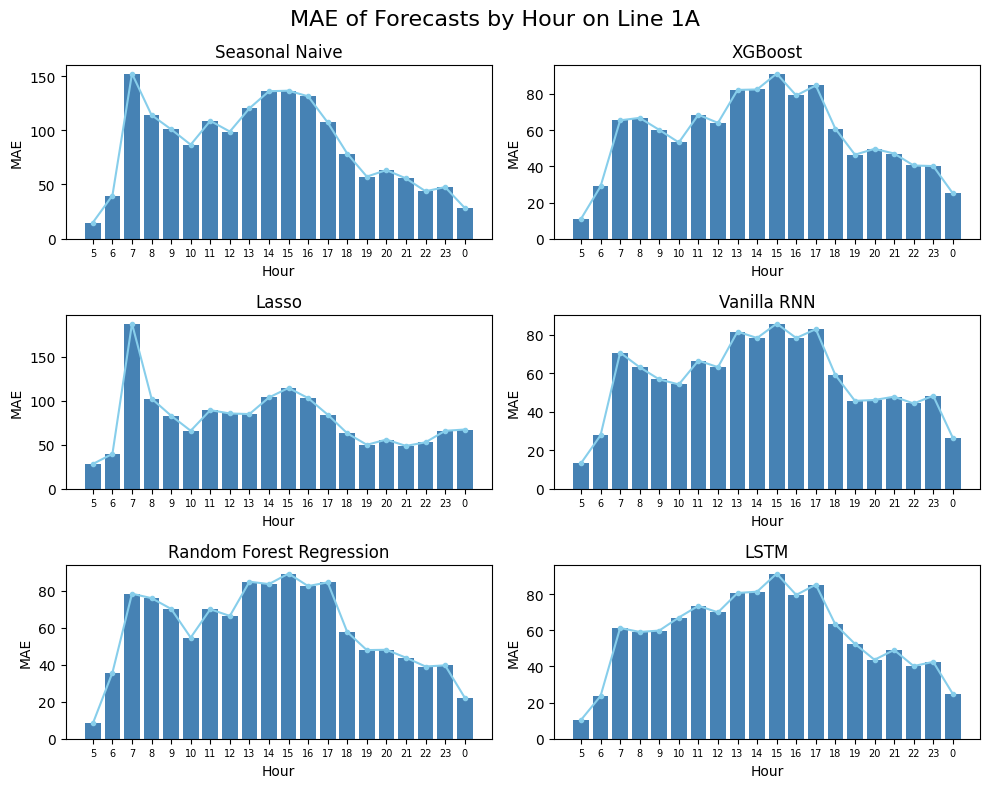

In [24]:
_, df_test = getData(60, Columns.line_1A.value, Columns.target_passengersBoarding.value)
plotPredErrorsGrouped("hour", preds_1A, model_names, df_test)

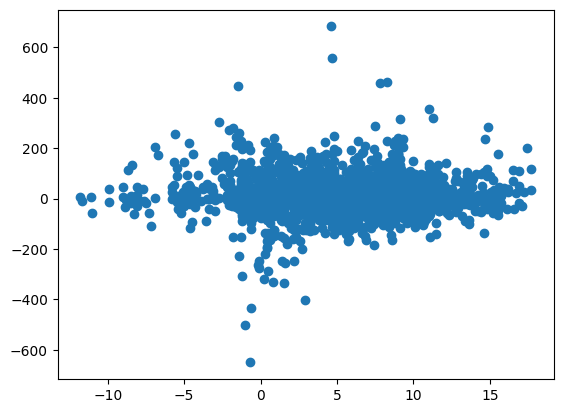

In [26]:
key = "mean_temp"
preds = RNN_preds1A
_, df_test = getData(60, Columns.line_1A.value, Columns.target_passengersBoarding.value)

pred_df = deepcopy(df_test)
pred_df["residuals"] = pred_df["passengersBoarding"] - preds

plt.scatter(pred_df[key], pred_df["residuals"])
#plt.xscale("log")